In [ ]:
from googleapiclient.discovery import build ##install package: pip insatll --upgrade google-api-python-client
from dateutil import parser
import pandas as pd
import os
from dotenv import load_dotenv

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

In [3]:
load_dotenv()
api_key = os.getenv("API_KEY")
api_service_name = 'youtube'
api_version = 'v3'
youtube = build(api_service_name, api_version, developerKey=api_key)
channel_ids = ['UCFtJHlYwZyb2ipqOGeNUs7Q',]##Viral Kingdom

In [4]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, statistics',
        id = ','.join(channel_ids))
    ## can format the response res with this online website:jsonlint.com
    response = request.execute()
    ## loop through items
    for item in response['items']:
        data = {
            'channel_name': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']}
        all_data.append(data)

    return (pd.DataFrame(all_data))

In [5]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [6]:
channel_stats

channel_name subscribers     views totalVideos                playlistId
0  Viral Kingdom       89400  11383818         343  UUFtJHlYwZyb2ipqOGeNUs7Q

In [7]:
playlist_id = 'UUFtJHlYwZyb2ipqOGeNUs7Q'

In [8]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        playlistId=playlist_id,
        maxResults=50)
    response = request.execute()
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token=response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='snippet,contentDetails',
                    playlistId=playlist_id,
                    maxResults=50,
                    pageToken=next_page_token)
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
    return video_ids

In [9]:
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)

343

In [12]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {
                'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                'contentDetails': ['duration', 'definition', 'caption']
            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube, video_ids)
video_df

video_id   channelTitle  \
0    MXpF5uch9qc  Viral Kingdom   
1    V0ZYvuGhTpk  Viral Kingdom   
2    aBA1pmdWXZg  Viral Kingdom   
3    XVTM965xnAQ  Viral Kingdom   
4    2X_rKmuhNC8  Viral Kingdom   
..           ...            ...   
338  JXXVN87t2_k  Viral Kingdom   
339  KMmItRLlsyo  Viral Kingdom   
340  VK6aOqa5Lpw  Viral Kingdom   
341  BHZupr_kkQ0  Viral Kingdom   
342  aM9BSOrejXU  Viral Kingdom   

                                                 title  \
0       The Future of the Metaverse - MetaCloud Review   
1      The Algorithmic Art NFT: Random Walk NFT Review   
2    How to Get Good Deals on NFTs With Bidding Auc...   
3    The First Story Based NFT Collection - Chief T...   
4    The Pioneer of Web3 Watches: Wrist Aficionado ...   
..                                                 ...   
338            Demi Lovato Gets Roasted Thug Life Vine   
339                     What Are Those Crack Kid Vine!   
340                                    MLG Daniel Cook   
341   Crack Kid Vine "Friday By Rebecca Black" Parody!   
342                           DEEZ NUTS Mcdonalds Vine   

                                           description  \
0    In today's NFT review we'll be going over the ...   
1    In todays NFT Review we'll be going over the R...   
2    In todays video we'll be going over the websit...   
3    In today's NFT review we'll be going over the ...   
4    In todays NFT Review we'll be going over the N...   
..                                                 ...   
338  If this video is seen any were else it is fake...   
339  If This video is seen any were else it is stol...   
340                              Daneil Cook is so MLG   
341  This Video is created and founded by me. If th...   
342  This video is created and founded by me. If se...   

                                                  tags           publishedAt  \
0    [nft, nft review, crypto, metaverse, metacloud...  2022-07-26T04:00:48Z   
1    [nft, nft review, algorithm, algorithm nft, nf...  2022-06-28T19:14:55Z   
2    [tutorial, nft, nft review, nft tutorial, nft ...  2022-06-16T21:08:05Z   
3    [nft, nft review, chief, toad, chief toad nft ...  2022-06-08T17:42:11Z   
4    [nft, nft review, crypto, wrist aficionado nft...  2022-06-02T05:19:00Z   
..                                                 ...                   ...   
338  [MLG, Vines, Vine, Daneil, Cook, DaneilCook, T...  2015-07-22T20:51:01Z   
339  [MLG, Vines, Vine, Daneil, Cook, DaneilCook, T...  2015-07-22T20:49:08Z   
340  [MLG, Vines, Vine, Daneil, Cook, DaneilCook, T...  2015-05-31T03:12:48Z   
341  [Crack, Kid, Vine, Rebecca, Black, RebeccaBlac...  2015-05-26T22:37:21Z   
342  [Deez Nuts (Musical Group), NUTS, Deez, DEEZ, ...  2015-04-19T14:25:02Z   

    viewCount likeCount favouriteCount commentCount duration definition  \
0        1738       117           None           44  PT7M34S         hd   
1        1522        38           None           24  PT3M42S         hd   
2         694        51           None           14  PT6M40S         hd   
3        2371        44           None           34  PT4M21S         hd   
4        1622        28           None            6  PT6M37S         hd   
..        ...       ...            ...          ...      ...        ...   
338       739        15           None            0    PT17S         sd   
339      1158        24           None         None     PT6S         hd   
340      1318        34           None         None    PT38S         sd   
341      1576        36           None         None     PT7S         sd   
342      3232        48           None            2     PT5S         hd   

    caption  
0     false  
1     false  
2     false  
3     false  
4     false  
..      ...  
338   false  
339   false  
340   false  
341   false  
342   false  

[343 rows x 13 columns]

In [16]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    for video_id in video_ids:
        try:           
            request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id)
            response = request.execute()
            print(response)
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
            
            all_comments.append(comments_in_video_info)
            
        except:
            print('Could not get comments for video ' + video_id)
    
    return pd.DataFrame(all_comments)

In [17]:
comments_df = get_comments_in_videos(youtube, video_ids)

{'kind': 'youtube#commentThreadListResponse', 'etag': 'xvu66Y_CzmWmR1K2nQE27A7YRwI', 'pageInfo': {'totalResults': 18, 'resultsPerPage': 20}, 'items': [{'kind': 'youtube#commentThread', 'etag': 'V7CiMbJCUCQSFobtGmfYN4zyOyw', 'id': 'UgyynwMJkoEp54rIoOZ4AaABAg', 'snippet': {'videoId': 'MXpF5uch9qc', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'MLlgJNNr76ha80IvpCle0CdjYIU', 'id': 'UgyynwMJkoEp54rIoOZ4AaABAg', 'snippet': {'videoId': 'MXpF5uch9qc', 'textDisplay': 'Can you tell me how to contact you regarding a collab ?', 'textOriginal': 'Can you tell me how to contact you regarding a collab ?', 'authorDisplayName': 'Nft universe', 'authorProfileImageUrl': 'https://yt3.ggpht.com/ytc/AMLnZu9DA4dd310md4JA0gpBnsqAoKcqoP-RufJgN5SHnKxnJhRNYFhu4pyGFB49h-_y=s48-c-k-c0x00ffffff-no-rj', 'authorChannelUrl': 'http://www.youtube.com/channel/UCn9Q9f4oFX7E8ibLh2CA9LQ', 'authorChannelId': {'value': 'UCn9Q9f4oFX7E8ibLh2CA9LQ'}, 'canRate': True, 'viewerRating': 'none', 'likeCount': 0, 'publishedAt'

Data pre-processing

In [18]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        343 non-null    object
 1   channelTitle    343 non-null    object
 2   title           343 non-null    object
 3   description     343 non-null    object
 4   tags            340 non-null    object
 5   publishedAt     343 non-null    object
 6   viewCount       343 non-null    object
 7   likeCount       337 non-null    object
 8   favouriteCount  0 non-null      object
 9   commentCount    340 non-null    object
 10  duration        343 non-null    object
 11  definition      343 non-null    object
 12  caption         343 non-null    object
dtypes: object(13)
memory usage: 35.0+ KB


In [19]:
## Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [20]:
## PUblish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [21]:
## convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
video_df[['durationSecs', 'duration']]

durationSecs duration
0           454.0  PT7M34S
1           222.0  PT3M42S
2           400.0  PT6M40S
3           261.0  PT4M21S
4           397.0  PT6M37S
..            ...      ...
338          17.0    PT17S
339           6.0     PT6S
340          38.0    PT38S
341           7.0     PT7S
342           5.0     PT5S

[343 rows x 2 columns]

In [23]:
## add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

EDA <br/>

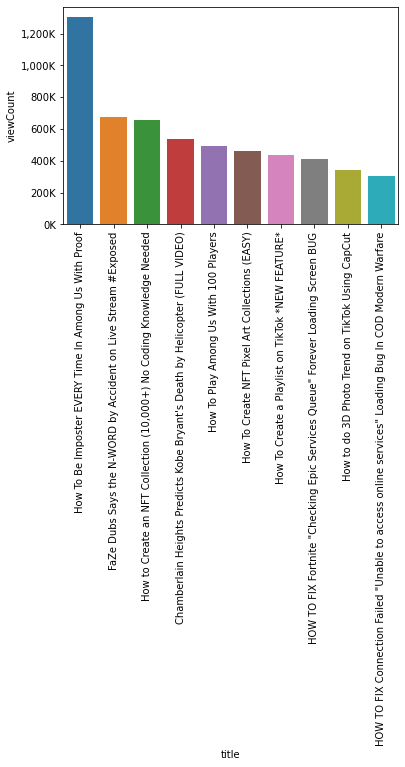

In [24]:
## Best performing videos
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:10])
plot=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000)+'K'))

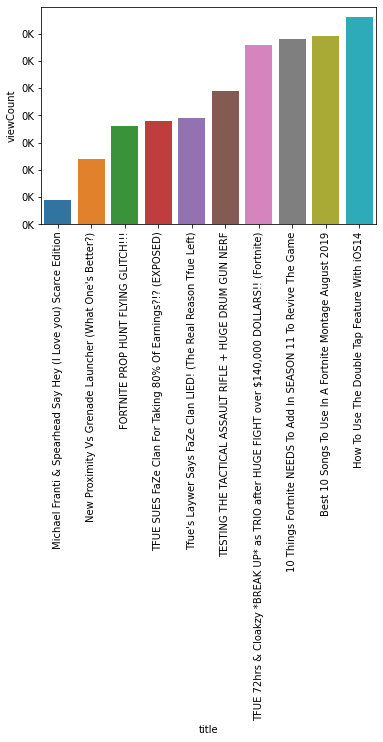

In [25]:
## Worst performing videos
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:10])
plot=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000)+'K'))

View distribution per video

c:\Users\yitonggu\Anaconda3\envs\scrap_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

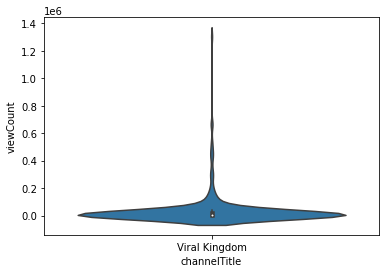

In [26]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

Views vs. Likes and Comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

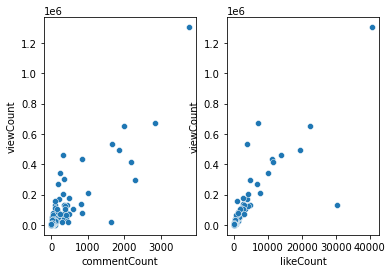

In [27]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data=video_df, x='commentCount', y='viewCount', ax=ax[0])
sns.scatterplot(data=video_df, x= 'likeCount', y='viewCount', ax=ax[1])

Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

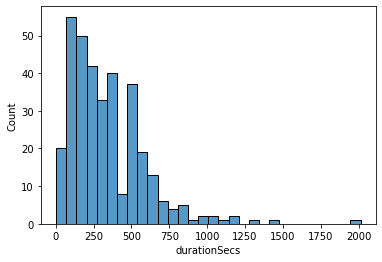

In [28]:
sns.histplot(data=video_df, x='durationSecs', bins=30)

Worldcloud for video titles

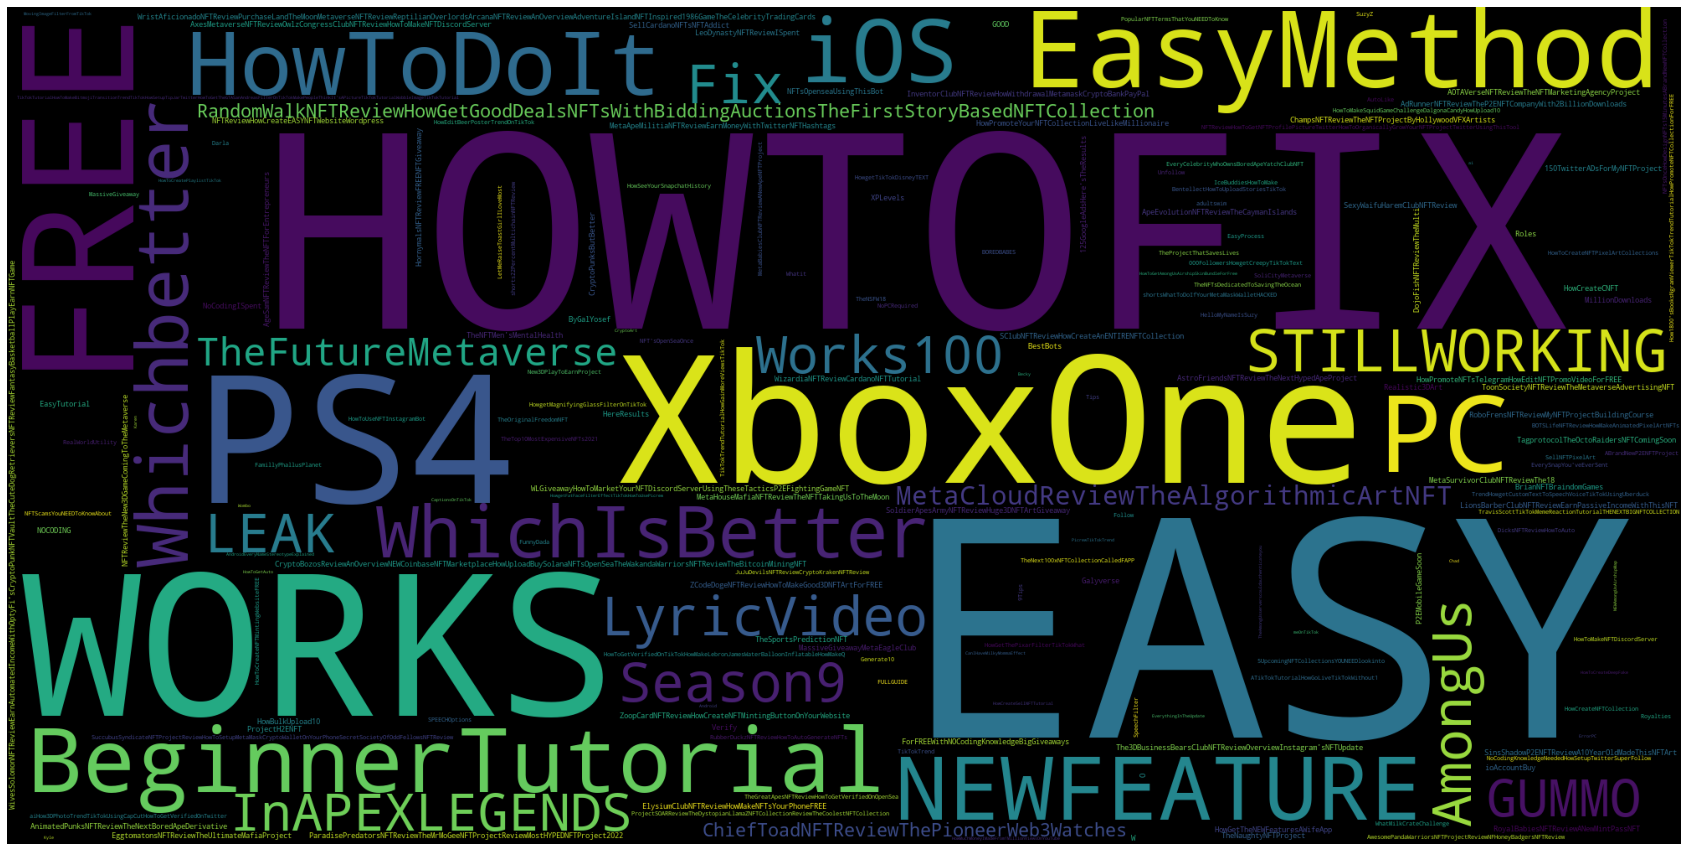

In [29]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ''.join(all_words)

def plot_clound(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off")
    
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_clound(wordcloud)

Upload schedule

Text(0, 0.5, 'Video Count')

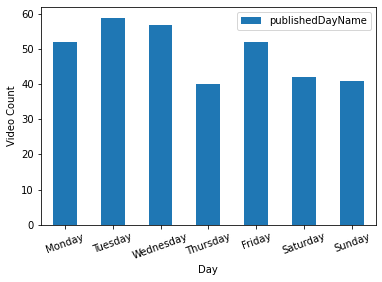

In [30]:
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishedDayName', rot=20)
ax.set_xlabel('Day')
ax.set_ylabel('Video Count')

Wordcloud for video comments

In [31]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

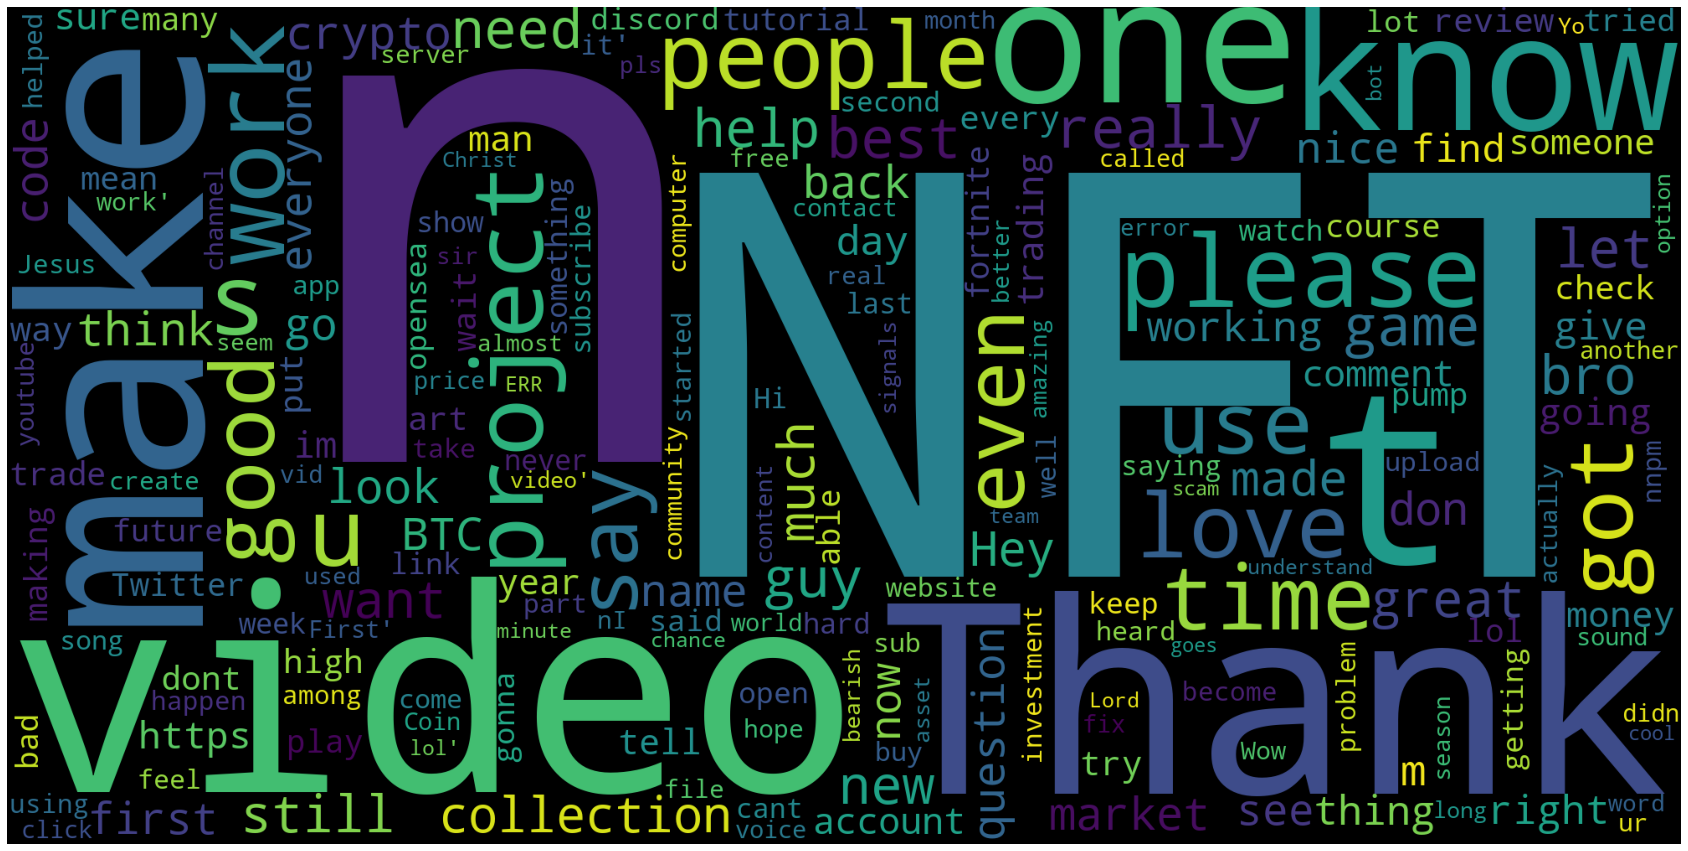

In [32]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_clound(wordcloud)